In [2]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

from dirichlet_actor_critic import Policy
from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
def select_action(state):
    state = state
    concentrations, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Dirichlet(concentrations)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (distribution of idle vehicles over cells)
    return list(action.numpy())

def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + args.gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),5.)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [3]:
# initialize args
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

args = namedtuple('args', ('render', 'gamma', 'log_interval'))
args.render= True
args.gamma = 0.99
args.log_interval = 10

In [4]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [6]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

### Load pre-trained policy and evaluate

In [7]:
model.load_state_dict(torch.load("ac_pretrained"))

<All keys matched successfully>

In [8]:
# Test Episodes
test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

# book-keeping variables
test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_rl_list = []

for episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, reward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v6Test/")
#             episode_reward += reward
            reward = torch.tensor([reward], device=device).float()
            episode_reward += reward.item()
            # Select and perform an RL action
            state = torch.tensor([obs[0][n][env.time] for n in model.region] + [env.dacc[n][env.time] for n in model.region] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            action_rl = select_action(state)
            action_rl_list.append(action_rl)
            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v6Test/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, reward, done, info = env.reb_step(rebAction)
            reward = torch.tensor([reward], device=device).float()
            new_state = torch.tensor([new_obs[0][n][env.time] for n in model.region] + [env.dacc[n][env.time] for n in model.region] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()

            # Move to the next state
            # track performance over episode
            episode_reward += reward.item()
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)

            # end episode if conditions reached
            if done:
                break
            
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 100 | Reward: 2150.03 | Revenue: 2482.83 | ServedDemand: 348.00 | Oper. Cost: 332.80: 100%|██████████| 100/100 [16:32<00:00,  9.92s/it]


In [18]:
# Plot results
print("Average Performance: \n")
print(f'Avg Reward: {np.mean(test_rewards):.2f}')
print(f'Avg Revenue: {np.mean(test_revenue):.2f}')
print(f'Avg Served Demand: {np.mean(test_served_demand):.2f}')
print(f'Avg Operating Cost: {np.mean(test_operating_cost):.2f}')

Average Performance: 

Avg Reward: 2102.42
Avg Revenue: 2434.58
Avg Served Demand: 336.16
Avg Operating Cost: 332.15


### Train model from scratch

In [4]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [6]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

In [8]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 10*500 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v6/")
            episode_reward += paxreward
            # Select and perform an RL action
            state = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            action_rl = select_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v6/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            new_state = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()

            # Store the transition in memory
            model.rewards.append(paxreward + rebreward)

            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            if done:
                break
        
        # perform backprop
        finish_episode()
        
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 5000 | Reward: 1980.15 | Revenue: 2309.15 | ServedDemand: 327.00 | Reb. Cost: 118.00 | Oper. Cost: 329.00: 100%|██████████| 5000/5000 [5:30:53<00:00,  3.97s/it]  


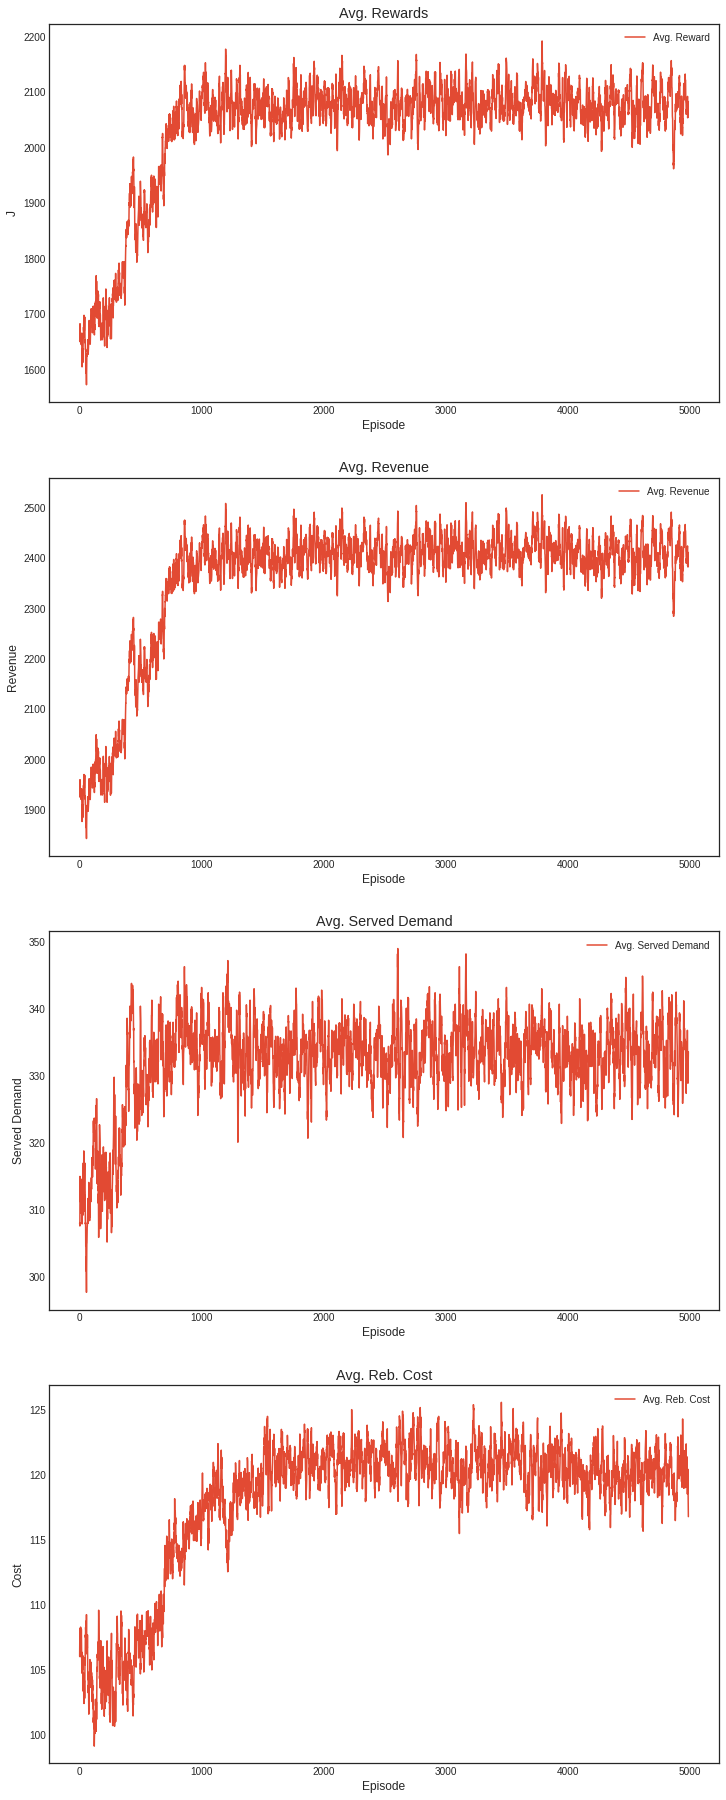

In [23]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()